In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from IPython import display
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

pd.set_option("display.max_columns", None)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [243]:
df = pd.read_csv('diabetes.csv').drop('Zodiac', axis = 1)
def toDummy(df, var):
    df = df.join(pd.get_dummies(df[var], prefix= var)).drop(var, axis = 1)
    return df
#df = df.join(pd.get_dummies(df['Zodiac'], prefix='Zodiac')).drop('Zodiac', axis = 1)

df = toDummy(df, 'BiologicalSex')
df = toDummy(df, 'AgeBracket')
df = toDummy(df, 'EducationBracket')
df = toDummy(df, 'IncomeBracket')

y = df['Diabetes']
X = df.iloc[:, 1:]
X = torch.tensor(X.values)
y = torch.tensor(y.values)
X = X.type(torch.FloatTensor)

N = len(X) #number of smaples
D = len(df.columns) - 1 # number of dimensions/features
C = 2 # number of classes
H = 100 # number of hidden units
df.describe()

df.Diabetes.sum() / len(df)

0.13933301797540207

### Build and train a Perceptron (one input layer, one output layer, no hidden layers and no activation functions) to classify diabetes from the rest of the dataset. What is the AUC of this model?

In [244]:
from sklearn.linear_model import Perceptron

In [245]:

pc = Perceptron()
# first see average CV score
pcAuc = cross_val_score(pc, X, y, scoring = 'roc_auc')
pcAuc.mean()

0.798921004826832

In [165]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state=628)
pc = Perceptron()
pc.fit(XTrain, yTrain)
pc._predict_proba_lr(XTest)
pred = pc._predict_proba_lr(XTest)[:,1]
pcAuc = roc_auc_score(yTest, pred)
pcAuc
# random state 42: 0.6956
# 41: 0.5005
# 628: 0.7456

0.7455881694086586

### Build and train a feedforward neural network with at least one hidden layer to classify diabetes from the rest of the dataset. Make sure to try different numbers of hidden layers and different activation functions (at a minimum reLU and sigmoid). Doing so: How does AUC vary as a function of the number of hidden layers and is it dependent on the kind of activation function used (make sure to include “no activation function” in your comparison). How does this network perform relative to the Perceptron? 

In [166]:
class Data(Dataset):
    def __init__(self, d):
        self.x = d.type(torch.FloatTensor)[:, 1:]
        self.y = d[:, 0]
        self.numSample = d.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.numSample


#def TRAIN(epoch, model, lossF, train_loader):
def TRAIN(epochs, model,lossF, trainloader, testloader):
    testL = []
    trainL = []
    trainAuc = []
    testAuc = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    for epoch in range(epochs): 
        trainLoss = 0.0

        trainAUC = 0.0

        model.train()
        for data in trainloader: 

            X, y = data 
            #model.zero_grad() 
            output = model(X) 
            
            try:
                auc = roc_auc_score(y, output.detach().numpy())
            except:
                predicted = torch.sigmoid(output)
                #print(predicted)
                auc = roc_auc_score(y, predicted.detach().numpy())
            trainAUC += auc


            optimizer.zero_grad()
            try: 
                loss = lossF(output, y.unsqueeze(1).type(torch.FloatTensor))  # calc and grab the loss value
            except:
                #print('Using BCEwithLogitLoss')
                lossF = nn.BCEWithLogitsLoss()
                loss = lossF(output, y.unsqueeze(1).type(torch.FloatTensor))
            trainLoss += loss.item()
            #print("[EPOCH]: %i, [LOSS]: %.6f" % (epoch, loss.item()))
            loss.backward()  # apply this loss backwards thru the network's parameters
            optimizer.step()  # attempt to optimize weights to account for loss/gradients


        valid_loss = 0.0
        model.eval() 
        vauc = 0.0
        with torch.no_grad():
            for data in testloader:
                q = 1
                # Transfer Data to GPU if available
                X, y = data
                output = model(X)
                try:
                    tauc = roc_auc_score(y, output.detach().numpy())
                except:
                    predicted = torch.sigmoid(output)
                    tauc = roc_auc_score(y, predicted.detach().numpy())
                vauc += tauc
                # Find the Loss
                try:
                    loss = criterion(output,y.unsqueeze(1).type(torch.FloatTensor))
                except:
                   # print('Using BCEwithLogitLoss')
                    lossF = nn.BCEWithLogitsLoss()
                    loss = lossF(output, y.unsqueeze(1).type(torch.FloatTensor))
                # Calculate Loss
                valid_loss += loss.item()
        testL.append(valid_loss / len(testloader))
        testAuc.append(vauc/len(testloader))
        trainL.append(trainLoss / len(trainloader))
        trainAuc.append(trainAUC/len(trainloader))
        #print('[Epoch]%d\t [Training Loss]: %f\t [Test Loss]: %f\t [Test Acc]: %f\t [Test AUC]: %f ' %  (epoch, (trainLoss / len(trainloader)), valid_loss / len(testloader) , tacc, tauc))
        print('[Epoch]%d\t [Training Loss]: %f\t [Test Loss]: %f\t [Train AUC]: %f\t [Test AUC]: %f ' %  (epoch, (trainLoss / len(trainloader)), valid_loss / len(testloader) ,  trainAUC / len(trainloader), vauc/ len(testloader)))
    return trainL, testL, trainAuc, testAuc



def TEST(model, testloader, criterion):
    model.eval()
    tacc = 0.0
    tauc = 0.0
    valid_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            X, y = data
            output = model(X)
            #tauc += roc_auc_score(y, output.detach().numpy())
            try:
                tauc += roc_auc_score(y, output.detach().numpy())
            except:
                predicted = torch.sigmoid(output)
                tauc += roc_auc_score(y, predicted.detach().numpy())
            # Find the Loss
            #loss = criterion(target,y.unsqueeze(1).type(torch.FloatTensor))
            try:
                loss = criterion(output,y.unsqueeze(1).type(torch.FloatTensor))
            except:
                lossF = nn.BCEWithLogitsLoss()
                loss = lossF(output, y.unsqueeze(1).type(torch.FloatTensor))
            # Calculate Loss
            valid_loss += loss.item()
    print('[Test Loss]: %f\t [Test AUC]: %f ' %  (valid_loss / len(testloader), tauc / len(testloader)))
    return valid_loss / len(testloader) , tauc / len(testloader)
class NN2Relu(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super().__init__()
        '''self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.fc2 = nn.Linear(hiddenSize, hiddenSize)
        self.fc3 = nn.Linear(hiddenSize, hiddenSize)
        self.fc4 = nn.Linear(hiddenSize, numClasses)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x)
        return torch.sigmoid(x)'''
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, numClasses),
            nn.Sigmoid(),
            )

    def forward(self, x):
        return self.layers(x)

        


### Setting up train and test sets

In [167]:
train, test = train_test_split(torch.tensor(df.values), test_size = 0.2, random_state=42)
#est, val = train_test_split(test, test_size = 0.4, random_state=42)
trainSet = Data(train)
trainloader = DataLoader(dataset=trainSet,batch_size=128, shuffle=True)
testSet = Data(test)
testloader = DataLoader(dataset=testSet,batch_size=1024, shuffle=True)
numEpoch = len(trainloader)

allAucs = []

## 2 Layer Relu

In [168]:
H = 32
lr = 1e-3
l2 = 1e-3
model = NN2Relu(len(df.columns) - 1, H, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2) 
q = 1

In [171]:
trainL, testL, trainAuc, testAuc = TRAIN(20, model, criterion, trainloader, testloader)

[Epoch]0	 [Training Loss]: 0.317049	 [Test Loss]: 0.310770	 [Train AUC]: 0.825446	 [Test AUC]: 0.830733 
[Epoch]1	 [Training Loss]: 0.317098	 [Test Loss]: 0.312888	 [Train AUC]: 0.825101	 [Test AUC]: 0.829179 
[Epoch]2	 [Training Loss]: 0.316920	 [Test Loss]: 0.311087	 [Train AUC]: 0.825470	 [Test AUC]: 0.829662 
[Epoch]3	 [Training Loss]: 0.316871	 [Test Loss]: 0.314287	 [Train AUC]: 0.824504	 [Test AUC]: 0.831284 
[Epoch]4	 [Training Loss]: 0.317019	 [Test Loss]: 0.312875	 [Train AUC]: 0.825234	 [Test AUC]: 0.830762 
[Epoch]5	 [Training Loss]: 0.316827	 [Test Loss]: 0.310147	 [Train AUC]: 0.825560	 [Test AUC]: 0.830512 
[Epoch]6	 [Training Loss]: 0.316562	 [Test Loss]: 0.310644	 [Train AUC]: 0.825475	 [Test AUC]: 0.830089 
[Epoch]7	 [Training Loss]: 0.316782	 [Test Loss]: 0.311179	 [Train AUC]: 0.825333	 [Test AUC]: 0.831398 
[Epoch]8	 [Training Loss]: 0.317066	 [Test Loss]: 0.312452	 [Train AUC]: 0.825127	 [Test AUC]: 0.829399 
[Epoch]9	 [Training Loss]: 0.317119	 [Test Loss]: 0.312

In [ ]:
def graph(train, test, ylabel, actF, numH, numN):
    plt.figure(figsize=(15,8))
    plt.plot(train, color = 'blue')
    plt.plot(test, color = 'orange')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(['train', 'test'])
    plt.title('%s %d Hidden Layers with %d neurons each' % (actF, numH, numN))
    plt.savefig('%s%dLayer%dNeuron%s' % (actF, numH, numN, ylabel))

#graph(trainL, testL, 'Loss','Relu',2, 32)
#graph(trainAuc, testAuc, 'AUC','Relu',2, 32)

### final AUC of 2 Layer Relu


In [ ]:
# final AUC of this model
model = NN2Relu(len(df.columns) - 1, H, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2) 
TRAIN(12, model, criterion, trainloader, testloader)
TwoLayerReluAUC = TEST(model, testloader, criterion)[1]
allAucs.append(TwoLayerReluAUC)
#[Test Loss]: 0.311974	 [Test AUC]: 0.830060 

[Epoch]0	 [Training Loss]: 0.340961	 [Test Loss]: 0.315460	 [Train AUC]: 0.770883	 [Test AUC]: 0.823049 
[Epoch]1	 [Training Loss]: 0.320834	 [Test Loss]: 0.315115	 [Train AUC]: 0.820406	 [Test AUC]: 0.826264 
[Epoch]2	 [Training Loss]: 0.319382	 [Test Loss]: 0.312276	 [Train AUC]: 0.822022	 [Test AUC]: 0.828576 
[Epoch]3	 [Training Loss]: 0.318877	 [Test Loss]: 0.311863	 [Train AUC]: 0.823328	 [Test AUC]: 0.827944 
[Epoch]4	 [Training Loss]: 0.318378	 [Test Loss]: 0.311608	 [Train AUC]: 0.823988	 [Test AUC]: 0.829341 
[Epoch]5	 [Training Loss]: 0.318004	 [Test Loss]: 0.315438	 [Train AUC]: 0.823676	 [Test AUC]: 0.830026 
[Epoch]6	 [Training Loss]: 0.318126	 [Test Loss]: 0.311535	 [Train AUC]: 0.824480	 [Test AUC]: 0.830364 
[Epoch]7	 [Training Loss]: 0.317792	 [Test Loss]: 0.314245	 [Train AUC]: 0.824702	 [Test AUC]: 0.828293 
[Epoch]8	 [Training Loss]: 0.317638	 [Test Loss]: 0.312594	 [Train AUC]: 0.824156	 [Test AUC]: 0.827782 
[Epoch]9	 [Training Loss]: 0.317641	 [Test Loss]: 0.310

In [ ]:
allAucs

[0.8307434232245354]

## 2 Layer Sigmoid

In [ ]:
class NN2Sig(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super().__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.fc2 = nn.Linear(hiddenSize, hiddenSize)
        self.fc3 = nn.Linear(hiddenSize, hiddenSize)
        self.fc4 = nn.Linear(hiddenSize, numClasses)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        #x = F.sigmoid(self.fc4(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

In [ ]:
D = len(df.columns) - 1
twoLayerSig = NN2Sig(D, H, 1)
#twoLayerRelu = NN2Relu(D,H,C)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(twoLayerSig.parameters(), lr=lr, weight_decay=l2) 

In [ ]:
trainL, testL, trainAuc, testAuc = TRAIN(20, twoLayerSig, criterion, trainloader, testloader)

tensor([[0.6418],
        [0.6421],
        [0.6419],
        [0.6421],
        [0.6420],
        [0.6421],
        [0.6421],
        [0.6417],
        [0.6421],
        [0.6420],
        [0.6417],
        [0.6420],
        [0.6422],
        [0.6422],
        [0.6422],
        [0.6421],
        [0.6421],
        [0.6421],
        [0.6421],
        [0.6422],
        [0.6421],
        [0.6421],
        [0.6421],
        [0.6420],
        [0.6422],
        [0.6422],
        [0.6421],
        [0.6420],
        [0.6421],
        [0.6417],
        [0.6419],
        [0.6420],
        [0.6421],
        [0.6421],
        [0.6422],
        [0.6421],
        [0.6421],
        [0.6421],
        [0.6421],
        [0.6421],
        [0.6421],
        [0.6422],
        [0.6421],
        [0.6422],
        [0.6421],
        [0.6417],
        [0.6422],
        [0.6420],
        [0.6421],
        [0.6419],
        [0.6420],
        [0.6421],
        [0.6416],
        [0.6418],
        [0.6421],
        [0

ValueError: multi_class must be in ('ovo', 'ovr')

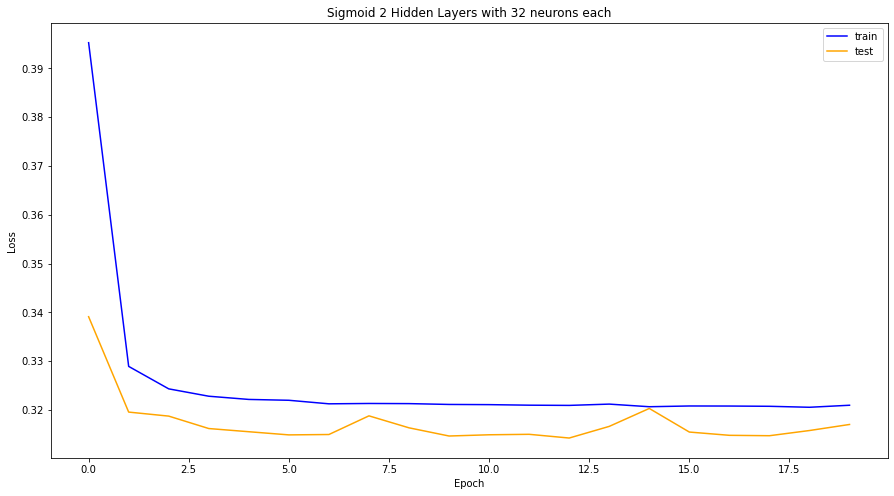

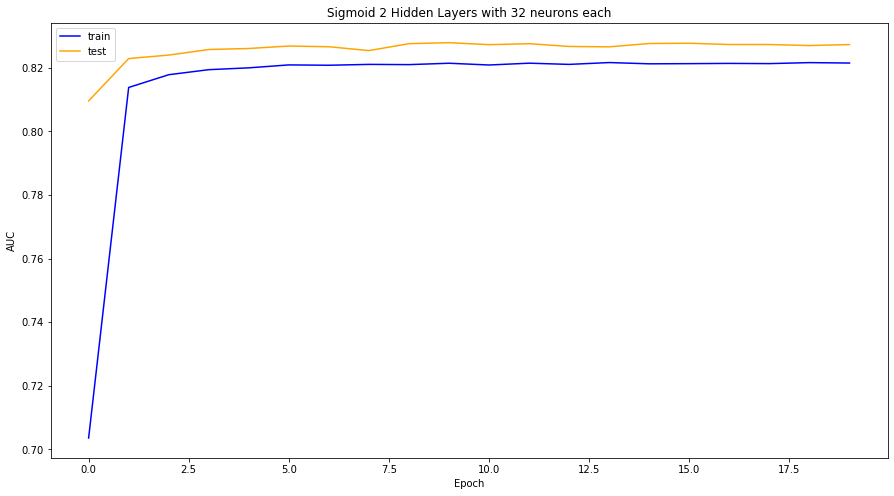

In [ ]:
graph(trainL, testL, 'Loss','Sigmoid',2, 32)
graph(trainAuc, testAuc, 'AUC','Sigmoid',2, 32)

In [ ]:
twoLayerSig = NN2Sig(D, H, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(twoLayerSig.parameters(), lr=lr, weight_decay=l2) 
TRAIN(10, twoLayerSig, criterion, trainloader, testloader)
testLoss, testAuc = TEST(twoLayerSig, testloader, criterion)
#[Test Loss]: 0.315540	 [Test Acc]: 0.000000	 [Test AUC]: 0.825059 
#allAucs.append(testAuc)

ValueError: multi_class must be in ('ovo', 'ovr')

## 1 Layer Relu, 1 Layer Sigmoid. 2 Layer No Activation, 1 Layer No Activation

In [ ]:
class NN1Relu(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super().__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.fc2 = nn.Linear(hiddenSize, hiddenSize)
        #self.fc3 = nn.Linear(hiddenSize, hiddenSize)
        self.fc4 = nn.Linear(hiddenSize, numClasses)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

class NN1Sig(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.Sigmoid(),
            nn.Linear(hiddenSize, hiddenSize),
            nn.Sigmoid(),
            nn.Linear(hiddenSize, numClasses),
            nn.Sigmoid()
            )

    def forward(self, x):
        return self.layers(x)

class NN10(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.Linear(hiddenSize, hiddenSize),
            nn.Linear(hiddenSize, numClasses),
            #nn.Sigmoid()
            )

    def forward(self, x):
        return self.layers(x)

class NN20(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.Linear(hiddenSize, hiddenSize),
            nn.Linear(hiddenSize, hiddenSize),
            nn.Linear(hiddenSize, numClasses),
            #nn.Sigmoid()
            )

    def forward(self, x):
        return self.layers(x)

class NN00(nn.Module):
    def __init__(self, inputSize):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, 1),
            #nn.Sigmoid()
            )

    def forward(self, x):
        return self.layers(x)


In [ ]:
oneLayerRelu = NN1Relu(D, H, 1)
oneLayerSig = NN1Sig(D,H,1)
oneLayerNo = NN10(D, H, 1)
twoLayerNo = NN20(D, H, 1)
zeroLayerNo = NN00(D)

In [ ]:
train(0, oneLayerRelu, trainloader)

Train Epoch: 0 [0/202944 (0%)]	Loss: 0.906775	AUC: 0.441667
Train Epoch: 0 [12800/202944 (6%)]	Loss: 0.694701	AUC: 0.285714
Train Epoch: 0 [25600/202944 (13%)]	Loss: 0.693279	AUC: 0.246998
Train Epoch: 0 [38400/202944 (19%)]	Loss: 0.693242	AUC: 0.208081
Train Epoch: 0 [51200/202944 (25%)]	Loss: 0.693241	AUC: 0.159292
Train Epoch: 0 [64000/202944 (32%)]	Loss: 0.693229	AUC: 0.242710
Train Epoch: 0 [76800/202944 (38%)]	Loss: 0.693236	AUC: 0.293578
Train Epoch: 0 [89600/202944 (44%)]	Loss: 0.693240	AUC: 0.284598
Train Epoch: 0 [102400/202944 (50%)]	Loss: 0.693219	AUC: 0.283267
Train Epoch: 0 [115200/202944 (57%)]	Loss: 0.693216	AUC: 0.188214
Train Epoch: 0 [128000/202944 (63%)]	Loss: 0.693223	AUC: 0.330973
Train Epoch: 0 [140800/202944 (69%)]	Loss: 0.693207	AUC: 0.262319
Train Epoch: 0 [153600/202944 (76%)]	Loss: 0.693214	AUC: 0.341492
Train Epoch: 0 [166400/202944 (82%)]	Loss: 0.693238	AUC: 0.469068
Train Epoch: 0 [179200/202944 (88%)]	Loss: 0.693223	AUC: 0.294617
Train Epoch: 0 [192000/2

[Epoch]0	 [Training Loss]: 0.353420	 [Test Loss]: 0.316955	 [Train AUC]: 0.768467	 [Test AUC]: 0.822869 
[Epoch]1	 [Training Loss]: 0.322756	 [Test Loss]: 0.318216	 [Train AUC]: 0.818512	 [Test AUC]: 0.824997 
[Epoch]2	 [Training Loss]: 0.321616	 [Test Loss]: 0.313506	 [Train AUC]: 0.820780	 [Test AUC]: 0.826406 
[Epoch]3	 [Training Loss]: 0.320609	 [Test Loss]: 0.319758	 [Train AUC]: 0.820712	 [Test AUC]: 0.826283 
[Epoch]4	 [Training Loss]: 0.319442	 [Test Loss]: 0.311564	 [Train AUC]: 0.822410	 [Test AUC]: 0.828658 
[Epoch]5	 [Training Loss]: 0.318957	 [Test Loss]: 0.312152	 [Train AUC]: 0.823222	 [Test AUC]: 0.829139 
[Epoch]6	 [Training Loss]: 0.318424	 [Test Loss]: 0.312451	 [Train AUC]: 0.823478	 [Test AUC]: 0.828657 
[Epoch]7	 [Training Loss]: 0.318448	 [Test Loss]: 0.312395	 [Train AUC]: 0.823921	 [Test AUC]: 0.828736 
[Epoch]8	 [Training Loss]: 0.317815	 [Test Loss]: 0.311465	 [Train AUC]: 0.824264	 [Test AUC]: 0.828895 
[Epoch]9	 [Training Loss]: 0.317915	 [Test Loss]: 0.311

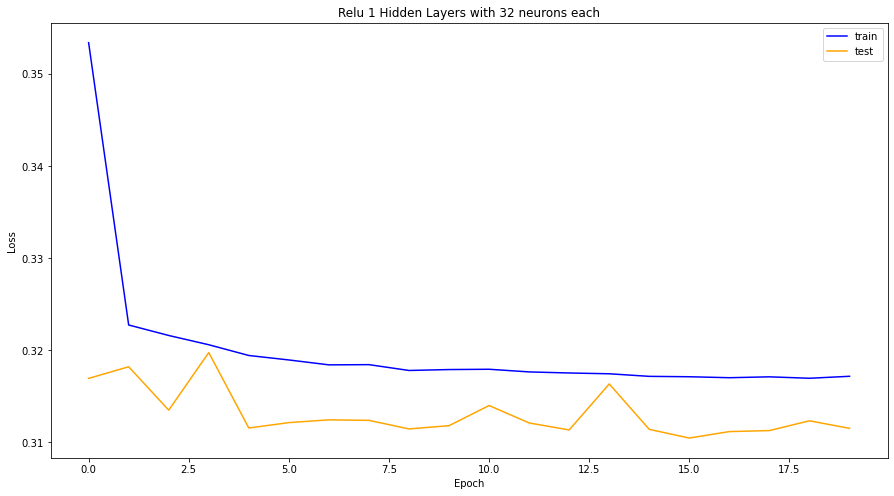

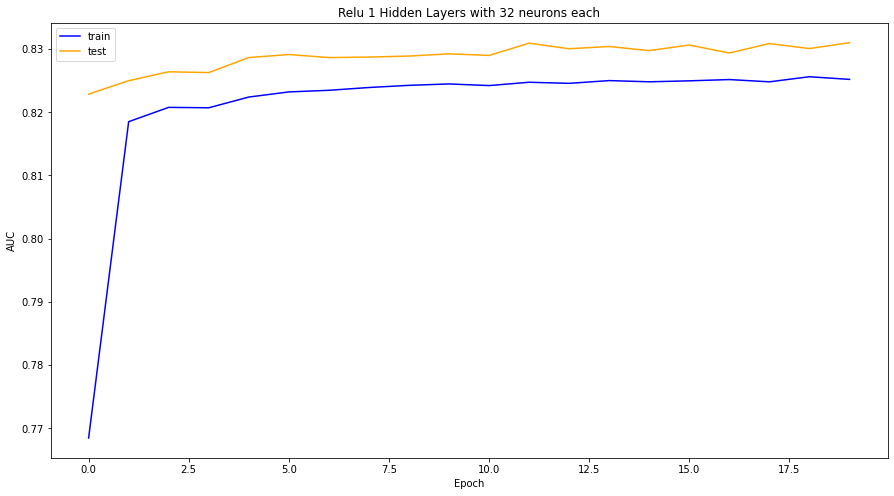

In [ ]:
trainL, testL, trainAuc, testAuc = TRAIN(20, oneLayerRelu, criterion, trainloader, testloader)
graph(trainL, testL, 'Loss','Relu',1, 32)
graph(trainAuc, testAuc, 'AUC','Relu',1, 32)

In [ ]:
oneLayerRelu = NN1Relu(D, H, 1)
TRAIN(12, oneLayerRelu, criterion, trainloader, testloader)

allAucs.append(TEST(oneLayerRelu, testloader, criterion)[1])

[Epoch]0	 [Training Loss]: 0.344836	 [Test Loss]: 0.318283	 [Train AUC]: 0.763589	 [Test AUC]: 0.820711 
[Epoch]1	 [Training Loss]: 0.322158	 [Test Loss]: 0.313600	 [Train AUC]: 0.818922	 [Test AUC]: 0.825439 
[Epoch]2	 [Training Loss]: 0.320594	 [Test Loss]: 0.313272	 [Train AUC]: 0.820857	 [Test AUC]: 0.828044 
[Epoch]3	 [Training Loss]: 0.319544	 [Test Loss]: 0.314032	 [Train AUC]: 0.822448	 [Test AUC]: 0.829251 
[Epoch]4	 [Training Loss]: 0.318563	 [Test Loss]: 0.312098	 [Train AUC]: 0.823380	 [Test AUC]: 0.828617 
[Epoch]5	 [Training Loss]: 0.318185	 [Test Loss]: 0.311459	 [Train AUC]: 0.824411	 [Test AUC]: 0.829948 
[Epoch]6	 [Training Loss]: 0.317919	 [Test Loss]: 0.311369	 [Train AUC]: 0.824022	 [Test AUC]: 0.829871 
[Epoch]7	 [Training Loss]: 0.317832	 [Test Loss]: 0.311226	 [Train AUC]: 0.823972	 [Test AUC]: 0.830071 
[Epoch]8	 [Training Loss]: 0.317790	 [Test Loss]: 0.311628	 [Train AUC]: 0.824771	 [Test AUC]: 0.829120 
[Epoch]9	 [Training Loss]: 0.317411	 [Test Loss]: 0.311

[Epoch]0	 [Training Loss]: 0.348533	 [Test Loss]: 0.320656	 [Train AUC]: 0.784127	 [Test AUC]: 0.822238 
[Epoch]1	 [Training Loss]: 0.323686	 [Test Loss]: 0.316882	 [Train AUC]: 0.817697	 [Test AUC]: 0.823397 
[Epoch]2	 [Training Loss]: 0.322239	 [Test Loss]: 0.315951	 [Train AUC]: 0.818698	 [Test AUC]: 0.824886 
[Epoch]3	 [Training Loss]: 0.321719	 [Test Loss]: 0.318684	 [Train AUC]: 0.819967	 [Test AUC]: 0.825131 
[Epoch]4	 [Training Loss]: 0.321586	 [Test Loss]: 0.315226	 [Train AUC]: 0.819619	 [Test AUC]: 0.825726 
[Epoch]5	 [Training Loss]: 0.321024	 [Test Loss]: 0.314329	 [Train AUC]: 0.820513	 [Test AUC]: 0.827107 
[Epoch]6	 [Training Loss]: 0.320840	 [Test Loss]: 0.315216	 [Train AUC]: 0.820255	 [Test AUC]: 0.825298 
[Epoch]7	 [Training Loss]: 0.321007	 [Test Loss]: 0.314495	 [Train AUC]: 0.820527	 [Test AUC]: 0.827055 
[Epoch]8	 [Training Loss]: 0.320859	 [Test Loss]: 0.317350	 [Train AUC]: 0.821204	 [Test AUC]: 0.825113 
[Epoch]9	 [Training Loss]: 0.320656	 [Test Loss]: 0.316

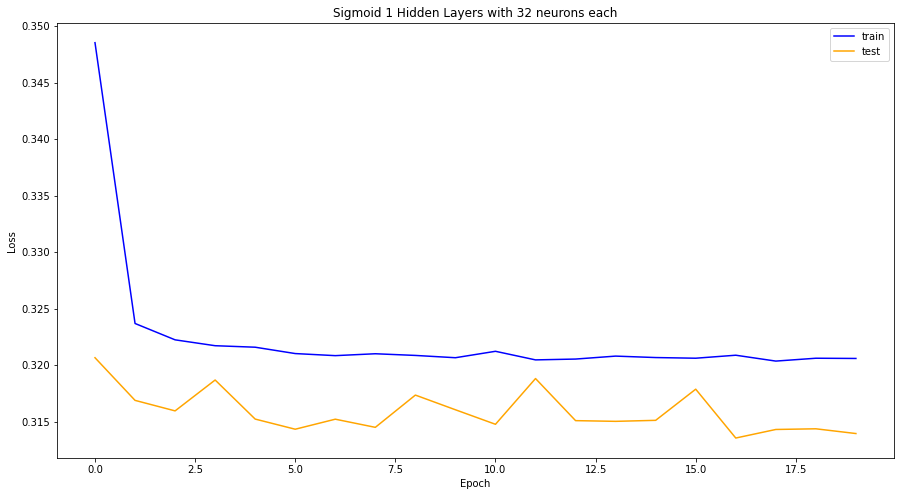

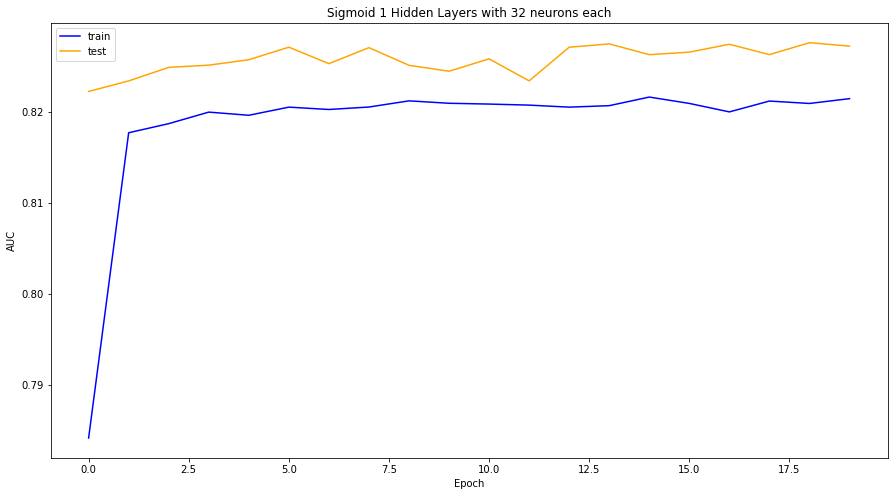

In [ ]:
trainL, testL, trainAuc, testAuc = TRAIN(20, oneLayerSig, criterion, trainloader, testloader)
graph(trainL, testL, 'Loss','Sigmoid',1, 32)
graph(trainAuc, testAuc, 'AUC','Sigmoid',1, 32)

In [ ]:
oneLayerSig = NN1Sig(D,H,1)
TRAIN(12, oneLayerSig, criterion, trainloader, testloader)
_, a = TEST(oneLayerSig, testloader, criterion)
allAucs.append(a)

[Epoch]0	 [Training Loss]: 0.358327	 [Test Loss]: 0.320781	 [Train AUC]: 0.766226	 [Test AUC]: 0.821018 
[Epoch]1	 [Training Loss]: 0.324491	 [Test Loss]: 0.321600	 [Train AUC]: 0.816754	 [Test AUC]: 0.823269 
[Epoch]2	 [Training Loss]: 0.322596	 [Test Loss]: 0.315972	 [Train AUC]: 0.818321	 [Test AUC]: 0.823880 
[Epoch]3	 [Training Loss]: 0.322148	 [Test Loss]: 0.315612	 [Train AUC]: 0.819102	 [Test AUC]: 0.825295 
[Epoch]4	 [Training Loss]: 0.321467	 [Test Loss]: 0.314506	 [Train AUC]: 0.820073	 [Test AUC]: 0.826250 
[Epoch]5	 [Training Loss]: 0.321393	 [Test Loss]: 0.316826	 [Train AUC]: 0.819773	 [Test AUC]: 0.825104 
[Epoch]6	 [Training Loss]: 0.321191	 [Test Loss]: 0.317180	 [Train AUC]: 0.820364	 [Test AUC]: 0.824806 
[Epoch]7	 [Training Loss]: 0.320933	 [Test Loss]: 0.314905	 [Train AUC]: 0.820761	 [Test AUC]: 0.826500 
[Epoch]8	 [Training Loss]: 0.320929	 [Test Loss]: 0.314191	 [Train AUC]: 0.820820	 [Test AUC]: 0.827365 
[Epoch]9	 [Training Loss]: 0.320941	 [Test Loss]: 0.314

[Epoch]0	 [Training Loss]: 0.343275	 [Test Loss]: 0.330169	 [Train AUC]: 0.774685	 [Test AUC]: 0.819569 
[Epoch]1	 [Training Loss]: 0.325548	 [Test Loss]: 0.318961	 [Train AUC]: 0.816819	 [Test AUC]: 0.822434 
[Epoch]2	 [Training Loss]: 0.324176	 [Test Loss]: 0.319667	 [Train AUC]: 0.818937	 [Test AUC]: 0.821736 
[Epoch]3	 [Training Loss]: 0.323869	 [Test Loss]: 0.315521	 [Train AUC]: 0.818531	 [Test AUC]: 0.825829 
[Epoch]4	 [Training Loss]: 0.323195	 [Test Loss]: 0.319410	 [Train AUC]: 0.819461	 [Test AUC]: 0.825404 
[Epoch]5	 [Training Loss]: 0.323294	 [Test Loss]: 0.321808	 [Train AUC]: 0.819078	 [Test AUC]: 0.825852 
[Epoch]6	 [Training Loss]: 0.322939	 [Test Loss]: 0.315272	 [Train AUC]: 0.819728	 [Test AUC]: 0.825754 
[Epoch]7	 [Training Loss]: 0.322758	 [Test Loss]: 0.319681	 [Train AUC]: 0.819614	 [Test AUC]: 0.825263 
[Epoch]8	 [Training Loss]: 0.322327	 [Test Loss]: 0.316123	 [Train AUC]: 0.819924	 [Test AUC]: 0.826105 
[Epoch]9	 [Training Loss]: 0.322366	 [Test Loss]: 0.315

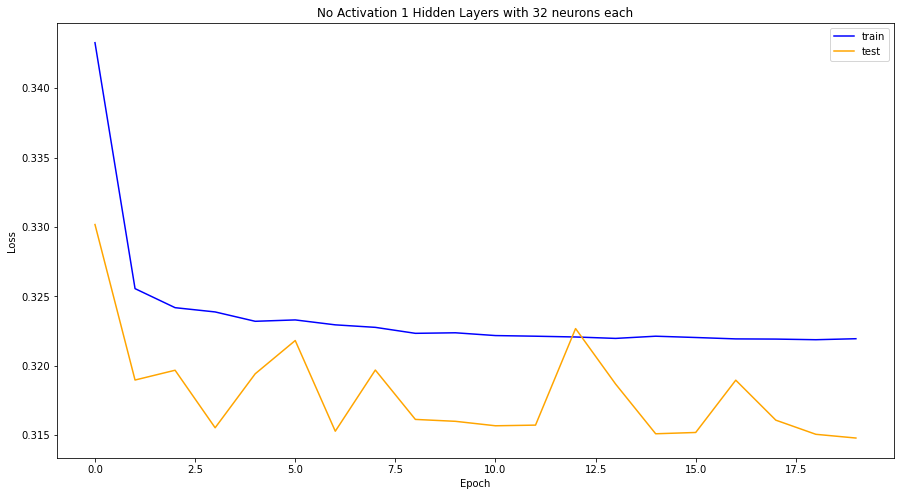

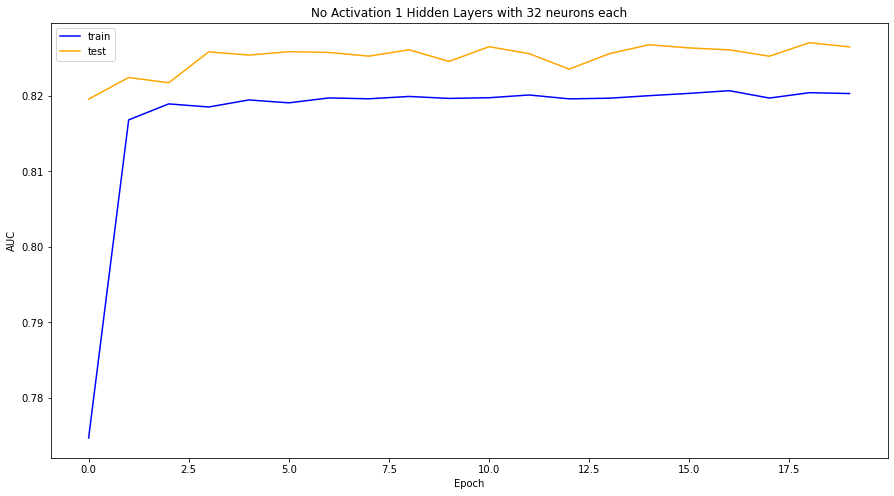

In [ ]:
trainL, testL, trainAuc, testAuc = TRAIN(20, oneLayerNo, criterion, trainloader, testloader)
graph(trainL, testL, 'Loss','No Activation',1, 32)
graph(trainAuc, testAuc, 'AUC','No Activation',1, 32)

In [ ]:
oneLayerNo = NN10(D, H, 1)
criterion = torch.nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
TRAIN(15, oneLayerNo, criterion, trainloader, testloader)
_, a = TEST(oneLayerNo, testloader, criterion)
#allAucs.append(a)

ValueError: multi_class must be in ('ovo', 'ovr')

[Epoch]0	 [Training Loss]: 0.338290	 [Test Loss]: 0.318522	 [Train AUC]: 0.783580	 [Test AUC]: 0.822573 
[Epoch]1	 [Training Loss]: 0.324693	 [Test Loss]: 0.321253	 [Train AUC]: 0.817763	 [Test AUC]: 0.825566 
[Epoch]2	 [Training Loss]: 0.324194	 [Test Loss]: 0.316056	 [Train AUC]: 0.818915	 [Test AUC]: 0.825880 
[Epoch]3	 [Training Loss]: 0.323764	 [Test Loss]: 0.317369	 [Train AUC]: 0.819076	 [Test AUC]: 0.826168 
[Epoch]4	 [Training Loss]: 0.323306	 [Test Loss]: 0.330629	 [Train AUC]: 0.819245	 [Test AUC]: 0.824763 
[Epoch]5	 [Training Loss]: 0.323404	 [Test Loss]: 0.318360	 [Train AUC]: 0.819565	 [Test AUC]: 0.824993 
[Epoch]6	 [Training Loss]: 0.322715	 [Test Loss]: 0.315640	 [Train AUC]: 0.819557	 [Test AUC]: 0.825970 
[Epoch]7	 [Training Loss]: 0.322614	 [Test Loss]: 0.321070	 [Train AUC]: 0.819802	 [Test AUC]: 0.825774 
[Epoch]8	 [Training Loss]: 0.322584	 [Test Loss]: 0.316012	 [Train AUC]: 0.819801	 [Test AUC]: 0.825816 
[Epoch]9	 [Training Loss]: 0.322189	 [Test Loss]: 0.315

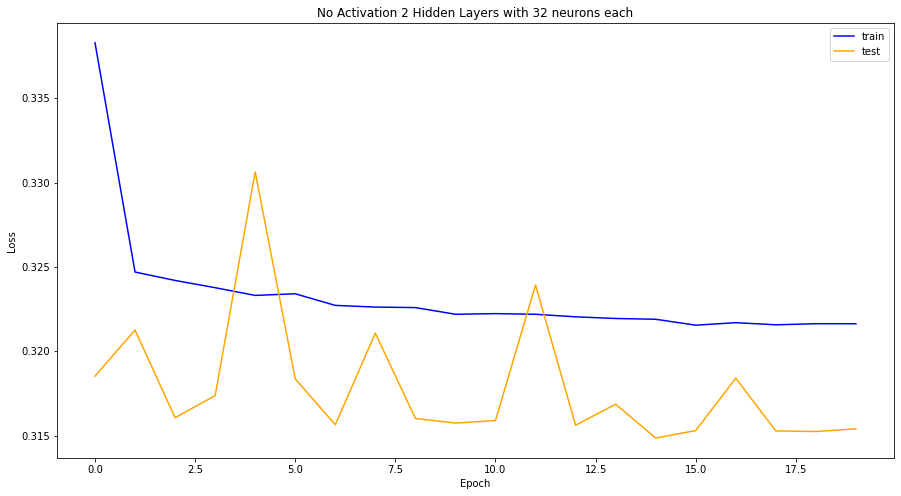

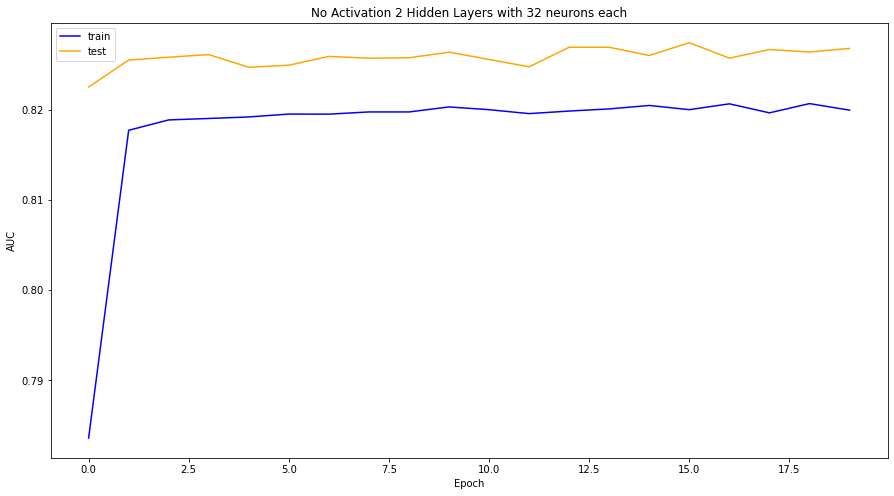

In [ ]:
trainL, testL, trainAuc, testAuc = TRAIN(20, twoLayerNo, criterion, trainloader, testloader)
graph(trainL, testL, 'Loss','No Activation',2, 32)
graph(trainAuc, testAuc, 'AUC','No Activation',2, 32)

In [ ]:
twoLayerNo = NN20(D, H, 1)
TRAIN(12, twoLayerNo, criterion, trainloader, testloader)
_, a = TEST(twoLayerNo, testloader, criterion)
allAucs.append(a)

[Epoch]0	 [Training Loss]: 0.340359	 [Test Loss]: 0.319073	 [Train AUC]: 0.782727	 [Test AUC]: 0.822469 
[Epoch]1	 [Training Loss]: 0.324953	 [Test Loss]: 0.322098	 [Train AUC]: 0.817619	 [Test AUC]: 0.826256 
[Epoch]2	 [Training Loss]: 0.324418	 [Test Loss]: 0.331717	 [Train AUC]: 0.818764	 [Test AUC]: 0.826316 
[Epoch]3	 [Training Loss]: 0.323703	 [Test Loss]: 0.318173	 [Train AUC]: 0.819045	 [Test AUC]: 0.826954 
[Epoch]4	 [Training Loss]: 0.323617	 [Test Loss]: 0.317085	 [Train AUC]: 0.819246	 [Test AUC]: 0.825606 
[Epoch]5	 [Training Loss]: 0.322842	 [Test Loss]: 0.315235	 [Train AUC]: 0.819877	 [Test AUC]: 0.826522 
[Epoch]6	 [Training Loss]: 0.322854	 [Test Loss]: 0.315856	 [Train AUC]: 0.818793	 [Test AUC]: 0.825489 
[Epoch]7	 [Training Loss]: 0.322560	 [Test Loss]: 0.321288	 [Train AUC]: 0.819737	 [Test AUC]: 0.827009 
[Epoch]8	 [Training Loss]: 0.322838	 [Test Loss]: 0.318205	 [Train AUC]: 0.819687	 [Test AUC]: 0.826119 
[Epoch]9	 [Training Loss]: 0.322501	 [Test Loss]: 0.317

In [ ]:
TRAIN(11, zeroLayerNo, criterion, trainloader, testloader)
_, a = TEST(zeroLayerNo, testloader, criterion)

allAucs.append(a)

[Epoch]0	 [Training Loss]: 0.359049	 [Test Loss]: 0.333463	 [Train AUC]: 0.743144	 [Test AUC]: 0.800035 
[Epoch]1	 [Training Loss]: 0.333882	 [Test Loss]: 0.326034	 [Train AUC]: 0.800860	 [Test AUC]: 0.812215 
[Epoch]2	 [Training Loss]: 0.328955	 [Test Loss]: 0.322604	 [Train AUC]: 0.808529	 [Test AUC]: 0.815851 
[Epoch]3	 [Training Loss]: 0.326665	 [Test Loss]: 0.321691	 [Train AUC]: 0.812210	 [Test AUC]: 0.819505 
[Epoch]4	 [Training Loss]: 0.325515	 [Test Loss]: 0.319796	 [Train AUC]: 0.814139	 [Test AUC]: 0.820332 
[Epoch]5	 [Training Loss]: 0.324904	 [Test Loss]: 0.319435	 [Train AUC]: 0.815431	 [Test AUC]: 0.820679 
[Epoch]6	 [Training Loss]: 0.324276	 [Test Loss]: 0.318885	 [Train AUC]: 0.816222	 [Test AUC]: 0.821699 
[Epoch]7	 [Training Loss]: 0.323986	 [Test Loss]: 0.318931	 [Train AUC]: 0.816255	 [Test AUC]: 0.821878 
[Epoch]8	 [Training Loss]: 0.323824	 [Test Loss]: 0.319287	 [Train AUC]: 0.816683	 [Test AUC]: 0.823034 
[Epoch]9	 [Training Loss]: 0.323540	 [Test Loss]: 0.318

In [ ]:
models = ['2 Layer Relu', '2 Layer Sigmoid','1 Layer Relu','1 Layer Sigmoid','1 Layer No Activation','2 Layer No Activation','0 Layer No Activation']
for ii in range(len(models)):
    print('%s AUC: %f' % (models[ii], allAucs[ii]))

2 Layer Relu AUC: 0.830743
2 Layer Sigmoid AUC: 0.826914
1 Layer Relu AUC: 0.830956
1 Layer Sigmoid AUC: 0.827287
1 Layer No Activation AUC: 0.826166
2 Layer No Activation AUC: 0.826173
0 Layer No Activation AUC: 0.823175


# Build and train a “deep” network (at least 2 hidden layers) to classify diabetes from the rest of the dataset. Given the nature of this dataset, is there a benefit of using a CNN or RNN for the classification?

In [ ]:
class NN4Relu(nn.Module):
    def __init__(self, inputSize):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, 50),
            nn.ReLU(),
            nn.Linear(50, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
            )

    def forward(self, x):
        return self.layers(x)


In [ ]:
fourLayerRelu = NN4Relu(len(df.columns) - 1)
criterion = torch.nn.BCELoss()
trainL, testL, trainAuc, testAuc = TRAIN(20, fourLayerRelu, criterion, trainloader, testloader)

[Epoch]0	 [Training Loss]: 0.336482	 [Test Loss]: 0.329274	 [Train AUC]: 0.782862	 [Test AUC]: 0.821572 
[Epoch]1	 [Training Loss]: 0.321898	 [Test Loss]: 0.313680	 [Train AUC]: 0.820852	 [Test AUC]: 0.826670 
[Epoch]2	 [Training Loss]: 0.320441	 [Test Loss]: 0.313121	 [Train AUC]: 0.821736	 [Test AUC]: 0.828389 
[Epoch]3	 [Training Loss]: 0.319496	 [Test Loss]: 0.312283	 [Train AUC]: 0.823110	 [Test AUC]: 0.829220 
[Epoch]4	 [Training Loss]: 0.319435	 [Test Loss]: 0.318555	 [Train AUC]: 0.823640	 [Test AUC]: 0.828798 
[Epoch]5	 [Training Loss]: 0.319292	 [Test Loss]: 0.311953	 [Train AUC]: 0.823405	 [Test AUC]: 0.828796 
[Epoch]6	 [Training Loss]: 0.318722	 [Test Loss]: 0.315573	 [Train AUC]: 0.823929	 [Test AUC]: 0.829184 
[Epoch]7	 [Training Loss]: 0.318595	 [Test Loss]: 0.311887	 [Train AUC]: 0.823751	 [Test AUC]: 0.830454 
[Epoch]8	 [Training Loss]: 0.318093	 [Test Loss]: 0.321552	 [Train AUC]: 0.823940	 [Test AUC]: 0.829374 
[Epoch]9	 [Training Loss]: 0.318085	 [Test Loss]: 0.311

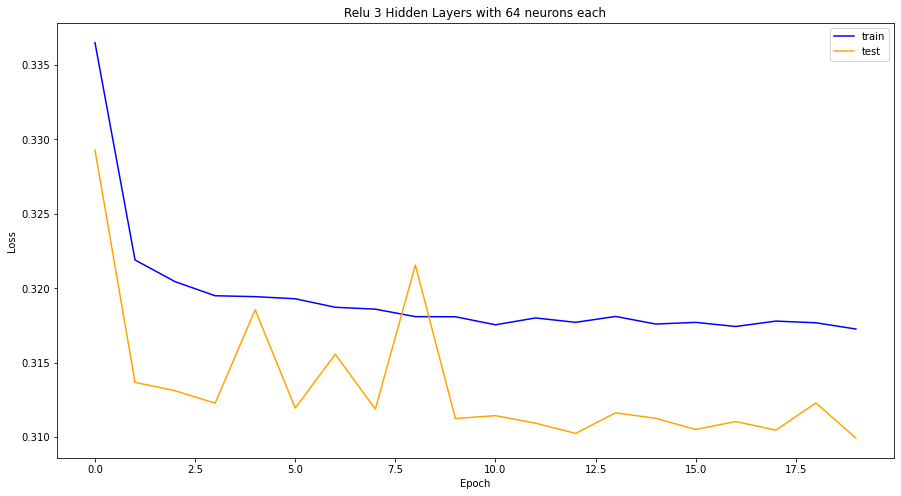

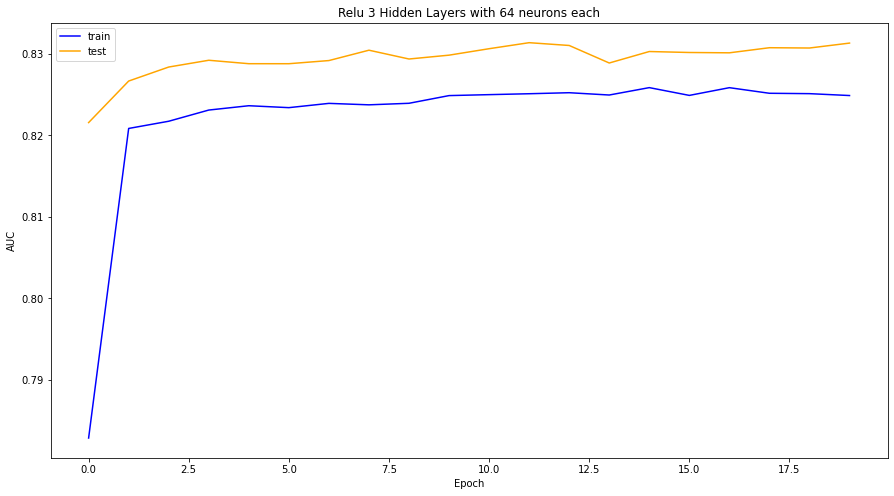

In [ ]:
graph(trainL, testL, 'Loss','Relu',3, 64)
graph(trainAuc, testAuc, 'AUC','Relu',3, 64)

In [ ]:
fourLayerRelu = NN4Relu(len(df.columns) - 1)
TRAIN(13, fourLayerRelu, criterion, trainloader, testloader)
TEST(fourLayerRelu, testloader, criterion)

[Epoch]0	 [Training Loss]: 0.337776	 [Test Loss]: 0.313851	 [Train AUC]: 0.782046	 [Test AUC]: 0.826150 
[Epoch]1	 [Training Loss]: 0.321399	 [Test Loss]: 0.317735	 [Train AUC]: 0.821045	 [Test AUC]: 0.826075 
[Epoch]2	 [Training Loss]: 0.319857	 [Test Loss]: 0.315383	 [Train AUC]: 0.822612	 [Test AUC]: 0.828535 
[Epoch]3	 [Training Loss]: 0.319144	 [Test Loss]: 0.311707	 [Train AUC]: 0.823425	 [Test AUC]: 0.829125 
[Epoch]4	 [Training Loss]: 0.319336	 [Test Loss]: 0.311700	 [Train AUC]: 0.824135	 [Test AUC]: 0.829772 
[Epoch]5	 [Training Loss]: 0.318838	 [Test Loss]: 0.311875	 [Train AUC]: 0.823872	 [Test AUC]: 0.829005 
[Epoch]6	 [Training Loss]: 0.318406	 [Test Loss]: 0.312905	 [Train AUC]: 0.824083	 [Test AUC]: 0.830609 
[Epoch]7	 [Training Loss]: 0.318614	 [Test Loss]: 0.311560	 [Train AUC]: 0.824594	 [Test AUC]: 0.829264 
[Epoch]8	 [Training Loss]: 0.317955	 [Test Loss]: 0.314258	 [Train AUC]: 0.824647	 [Test AUC]: 0.829194 
[Epoch]9	 [Training Loss]: 0.318028	 [Test Loss]: 0.315

(0.3127353525161743, 0.829612212033274)

# Build and train a feedforward neural network with one hidden layer to predict BMI from the rest of the dataset. Use RMSE to assess the accuracy of your model. Does the RMSE depend on the activation function used?  

In [172]:
first_column = df.pop('BMI')
df.insert(0, 'BMI', first_column)
df

BMI  Diabetes  HighBP  HighChol  Smoker  Stroke  Myocardial  \
0        40         0       1         1       1       0           0   
1        25         0       0         0       1       0           0   
2        28         0       1         1       0       0           0   
3        27         0       1         0       0       0           0   
4        24         0       1         1       0       0           0   
...     ...       ...     ...       ...     ...     ...         ...   
253675   45         0       1         1       0       0           0   
253676   18         1       1         1       0       0           0   
253677   28         0       0         0       0       0           0   
253678   23         0       1         0       0       0           0   
253679   25         1       1         1       0       0           1   

        PhysActivity  Fruit  Vegetables  HeavyDrinker  HasHealthcare  \
0                  0      0           1             0              1   
1                  1      0           0             0              0   
2                  0      1           0             0              1   
3                  1      1           1             0              1   
4                  1      1           1             0              1   
...              ...    ...         ...           ...            ...   
253675             0      1           1             0              1   
253676             0      0           0             0              1   
253677             1      1           0             0              1   
253678             0      1           1             0              1   
253679             1      1           0             0              1   

        NotAbleToAffordDoctor  GeneralHealth  MentalHealth  PhysicalHealth  \
0                           0              5            18              15   
1                           1              3             0               0   
2                           1              5            30              30   
3                           0              2             0               0   
4                           0              2             3               0   
...                       ...            ...           ...             ...   
253675                      0              3             0               5   
253676                      0              4             0               0   
253677                      0              1             0               0   
253678                      0              3             0               0   
253679                      0              2             0               0   

        HardToClimbStairs  BiologicalSex_1  BiologicalSex_2  AgeBracket_1  \
0                       1                1                0             0   
1                       0                1                0             0   
2                       1                1                0             0   
3                       0                1                0             0   
4                       0                1                0             0   
...                   ...              ...              ...           ...   
253675                  0                0                1             0   
253676                  1                1                0             0   
253677                  0                1                0             0   
253678                  0                0                1             0   
253679                  0                1                0             0   

        AgeBracket_2  AgeBracket_3  AgeBracket_4  AgeBracket_5  AgeBracket_6  \
0                  0             0             0             0             0   
1                  0             0             0             0             0   
2                  0             0             0             0             0   
3                  0             0             0             0             0   
4                  0        

In [173]:
train, test = train_test_split(torch.tensor(df.values), test_size = 0.2, random_state=42)
#est, val = train_test_split(test, test_size = 0.4, random_state=42)
trainSet = Data(train)
trainloader = DataLoader(dataset=trainSet,batch_size=128, shuffle=True)
testSet = Data(test)
testloader = DataLoader(dataset=testSet,batch_size=1024, shuffle=True)
numEpoch = len(trainloader)

In [208]:
class NNR(nn.Module):
    def __init__(self, inputSize, hiddenSize, numClasses):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, numClasses),
            #nn.Linear(),
            )

    def forward(self, x):
        return self.layers(x)

In [240]:
from sklearn.metrics import mean_squared_error as MSE
def RTRAIN(epochs, model,trainloader, testloader):
    testL = []
    trainL = []
    trainAuc = []
    testAuc = []
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)
    lossF = nn.MSELoss()
    for epoch in range(epochs): 
        trainLoss = 0.0
        trainAUC = 0.0
        model.train()
        for data in trainloader: 
            X, y = data 
            output = model(X)
            trainAUC += MSE(y, output.detach().numpy())**0.5

            optimizer.zero_grad()
            loss = torch.sqrt(lossF(output, y.unsqueeze(1).type(torch.FloatTensor)))  # calc and grab the loss value
            trainLoss += loss.item()

            loss.backward()  # apply this loss backwards thru the network's parameters
            optimizer.step()  # attempt to optimize weights to account for loss/gradients


        valid_loss = 0.0
        model.eval() 
        vauc = 0.0
        with torch.no_grad():
            for data in testloader:
                q = 1
                # Transfer Data to GPU if available
                X, y = data
                output = model(X)
                vauc += MSE(y, output.detach().numpy())**0.5
                # Find the Loss
                loss = torch.sqrt(lossF(output,y.unsqueeze(1).type(torch.FloatTensor)))

                # Calculate Loss
                valid_loss += loss.item()
        testL.append(valid_loss / len(testloader))
        testAuc.append(vauc/len(testloader))
        trainL.append(trainLoss / len(trainloader))
        trainAuc.append(trainAUC/len(trainloader))
        #print('[Epoch]%d\t [Training Loss]: %f\t [Test Loss]: %f\t [Test Acc]: %f\t [Test AUC]: %f ' %  (epoch, (trainLoss / len(trainloader)), valid_loss / len(testloader) , tacc, tauc))
        print('[Epoch]%d\t [Training Loss]: %f\t [Test Loss]: %f\t [Train RMSE]: %f\t [Test RMSE]: %f ' %  (epoch, (trainLoss / len(trainloader)), valid_loss / len(testloader) ,  trainAUC / len(trainloader), vauc/ len(testloader)))
    return trainL, testL, trainAuc, testAuc

def RTEST(model, testloader):
    model.eval()
    tacc = 0.0
    tauc = 0.0
    valid_loss = 0.0
    lossF = nn.MSELoss()
    with torch.no_grad():
        for data in testloader:
            X, y = data
            output = model(X)
            #tauc += roc_auc_score(y, output.detach().numpy())
            tauc += np.sqrt(MSE(y, output.detach().numpy()))
            # Find the Loss
            #loss = criterion(target,y.unsqueeze(1).type(torch.FloatTensor))
            loss = torch.sqrt(lossF(output, y.unsqueeze(1).type(torch.FloatTensor)))  # calc and grab the loss value

            # Calculate Loss
            valid_loss += loss.item()
    print('[Test Loss]: %f\t [Test RMSE]: %f ' %  (valid_loss / len(testloader), tauc / len(testloader)))
    return valid_loss / len(testloader) , tauc / len(testloader)

In [236]:
#regre = NNR(len(df.columns) - 1, 50, 1)
regre = nn.Sequential(
        nn.Linear(len(df.columns) - 1, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
)

regre1 = nn.Sequential(
        nn.Linear(len(df.columns) - 1, 50),
        nn.ReLU(),
        nn.Linear(50, 1),
)
train, test = train_test_split(torch.tensor(df.values), test_size = 0.2, random_state=98)
#est, val = train_test_split(test, test_size = 0.4, random_state=42)

testSet = Data(test)
testloader = DataLoader(dataset=testSet,batch_size=1024, shuffle=True)


In [232]:
trainL, testL, trainAuc, testAuc = RTRAIN(20, regre1, trainloader, testloader)

[Epoch]0	 [Training Loss]: 11.062570	 [Test Loss]: 6.424241	 [Train RMSE]: 11.062570	 [Test RMSE]: 6.424241 
[Epoch]1	 [Training Loss]: 6.195184	 [Test Loss]: 6.107160	 [Train RMSE]: 6.195184	 [Test RMSE]: 6.107160 
[Epoch]2	 [Training Loss]: 6.049771	 [Test Loss]: 6.050786	 [Train RMSE]: 6.049771	 [Test RMSE]: 6.050786 
[Epoch]3	 [Training Loss]: 6.016124	 [Test Loss]: 6.043223	 [Train RMSE]: 6.016124	 [Test RMSE]: 6.043223 
[Epoch]4	 [Training Loss]: 5.999336	 [Test Loss]: 6.008689	 [Train RMSE]: 5.999336	 [Test RMSE]: 6.008689 
[Epoch]5	 [Training Loss]: 5.985446	 [Test Loss]: 6.010407	 [Train RMSE]: 5.985445	 [Test RMSE]: 6.010407 
[Epoch]6	 [Training Loss]: 5.982859	 [Test Loss]: 6.000277	 [Train RMSE]: 5.982859	 [Test RMSE]: 6.000277 
[Epoch]7	 [Training Loss]: 5.976637	 [Test Loss]: 6.002677	 [Train RMSE]: 5.976637	 [Test RMSE]: 6.002677 
[Epoch]8	 [Training Loss]: 5.970336	 [Test Loss]: 5.995049	 [Train RMSE]: 5.970336	 [Test RMSE]: 5.995049 
[Epoch]9	 [Training Loss]: 5.965364

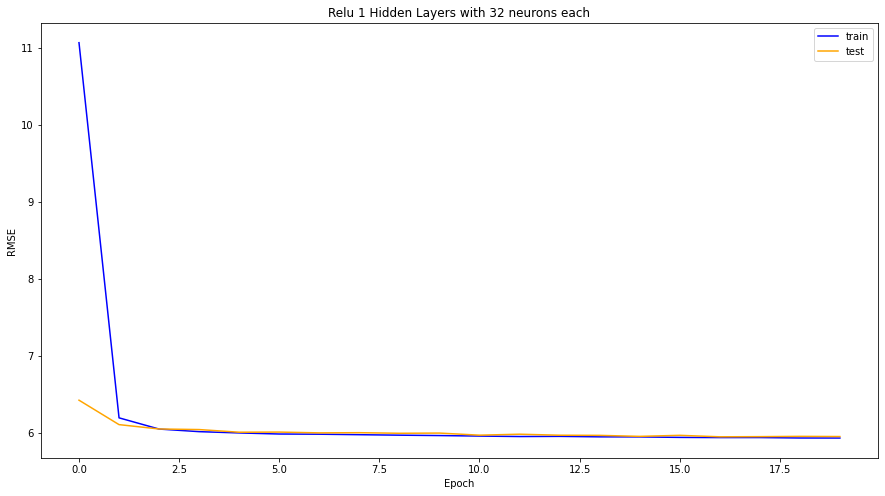

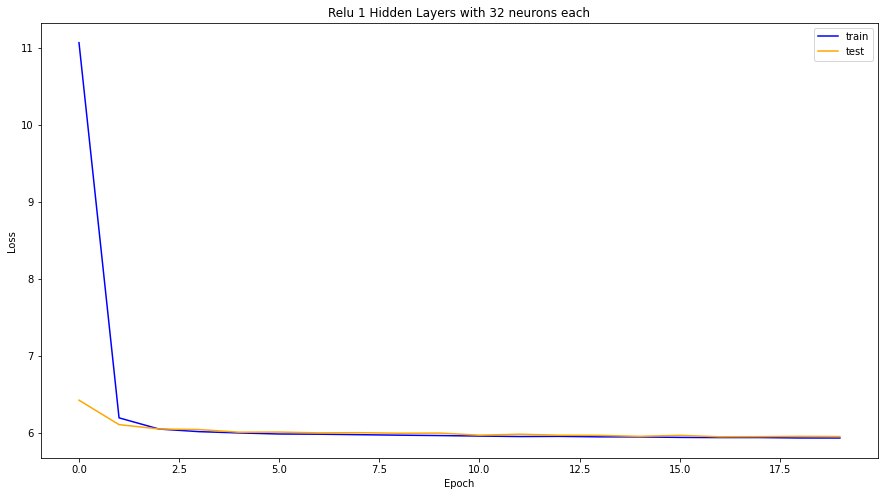

In [234]:
graph(trainAuc, testAuc, 'RMSE','Relu',1, 32)
graph(trainL, testL, 'Loss','Relu',1, 32)

In [241]:
RTEST(regre1, valloader)

NameError: name 'valloader' is not defined

In [227]:
trainL, testL, trainAuc, testAuc = RTRAIN(12, regre, trainloader, testloader)

[Epoch]0	 [Training Loss]: 8.055118	 [Test Loss]: 6.067126	 [Train RMSE]: 8.055118	 [Test RMSE]: 6.067126 
[Epoch]1	 [Training Loss]: 6.026039	 [Test Loss]: 6.035404	 [Train RMSE]: 6.026039	 [Test RMSE]: 6.035404 
[Epoch]2	 [Training Loss]: 6.008687	 [Test Loss]: 6.014341	 [Train RMSE]: 6.008687	 [Test RMSE]: 6.014341 
[Epoch]3	 [Training Loss]: 5.992141	 [Test Loss]: 5.987524	 [Train RMSE]: 5.992141	 [Test RMSE]: 5.987524 
[Epoch]4	 [Training Loss]: 5.982616	 [Test Loss]: 5.992576	 [Train RMSE]: 5.982616	 [Test RMSE]: 5.992576 
[Epoch]5	 [Training Loss]: 5.977817	 [Test Loss]: 6.018646	 [Train RMSE]: 5.977817	 [Test RMSE]: 6.018645 
[Epoch]6	 [Training Loss]: 5.959117	 [Test Loss]: 5.982665	 [Train RMSE]: 5.959117	 [Test RMSE]: 5.982665 
[Epoch]7	 [Training Loss]: 5.945171	 [Test Loss]: 5.941102	 [Train RMSE]: 5.945171	 [Test RMSE]: 5.941102 
[Epoch]8	 [Training Loss]: 5.935010	 [Test Loss]: 5.956562	 [Train RMSE]: 5.935010	 [Test RMSE]: 5.956562 
[Epoch]9	 [Training Loss]: 5.932160	 

In [238]:
RTEST(regre, testloader)

[Test Loss]: 29.098644	 [Test AUC]: 29.098644 


(29.098644027709963, 29.09864399441817)

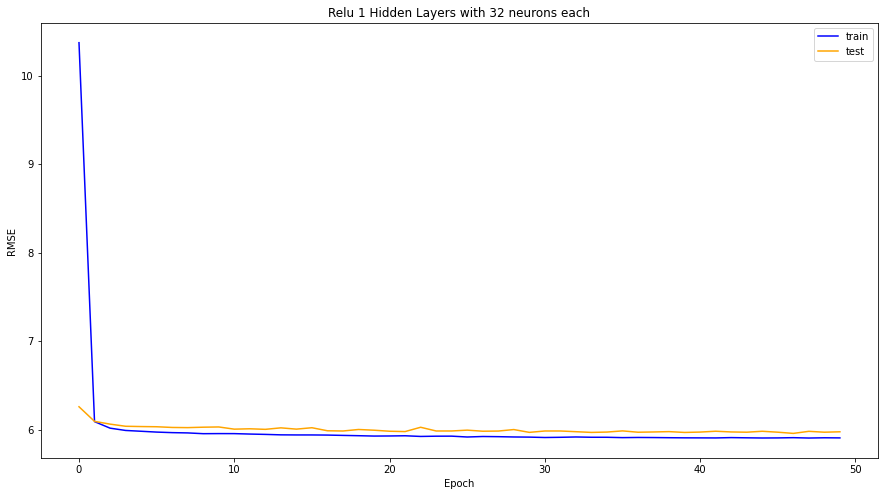

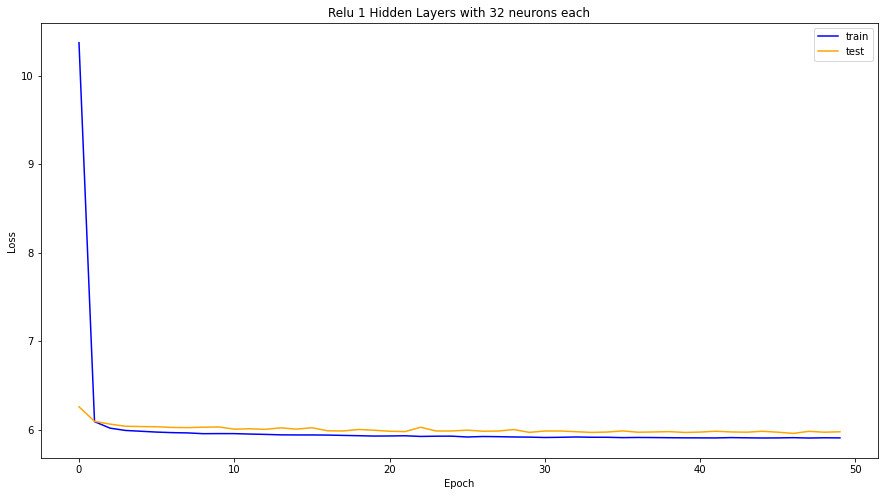

In [221]:
graph(trainAuc, testAuc, 'RMSE','Relu',1, 32)
graph(trainL, testL, 'Loss','Relu',1, 32)

In [187]:
from sklearn.ensemble import RandomForestRegressor
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
X

Diabetes  HighBP  HighChol  Smoker  Stroke  Myocardial  PhysActivity  \
0              0       1         1       1       0           0             0   
1              0       0         0       1       0           0             1   
2              0       1         1       0       0           0             0   
3              0       1         0       0       0           0             1   
4              0       1         1       0       0           0             1   
...          ...     ...       ...     ...     ...         ...           ...   
253675         0       1         1       0       0           0             0   
253676         1       1         1       0       0           0             0   
253677         0       0         0       0       0           0             1   
253678         0       1         0       0       0           0             0   
253679         1       1         1       0       0           1             1   

        Fruit  Vegetables  HeavyDrinker  HasHealthcare  NotAbleToAffordDoctor  \
0           0           1             0              1                      0   
1           0           0             0              0                      1   
2           1           0             0              1                      1   
3           1           1             0              1                      0   
4           1           1             0              1                      0   
...       ...         ...           ...            ...                    ...   
253675      1           1             0              1                      0   
253676      0           0             0              1                      0   
253677      1           0             0              1                      0   
253678      1           1             0              1                      0   
253679      1           0             0              1                      0   

        GeneralHealth  MentalHealth  PhysicalHealth  HardToClimbStairs  \
0                   5            18              15                  1   
1                   3             0               0                  0   
2                   5            30              30                  1   
3                   2             0               0                  0   
4                   2             3               0                  0   
...               ...           ...             ...                ...   
253675              3             0               5                  0   
253676              4             0               0                  1   
253677              1             0               0                  0   
253678              3             0               0                  0   
253679              2             0               0                  0   

        BiologicalSex_1  BiologicalSex_2  AgeBracket_1  AgeBracket_2  \
0                     1                0             0             0   
1                     1                0             0             0   
2                     1                0             0             0   
3                     1                0             0             0   
4                     1                0             0             0   
...                 ...              ...           ...           ...   
253675                0                1             0             0   
253676                1                0             0             0   
253677                1                0             0             1   
253678                0                1             0             0   
253679                1                0             0             0   

        AgeBracket_3  AgeBracket_4  AgeBracket_5  AgeBracket_6  AgeBracket_7  \
0                  0             0             0             0             0   
1                  0             0             0             0             1   
2                  0             0             0             0             0   


In [206]:
rf = RandomForestRegressor(n_jobs = -1, verbose= 1)
rf.fit(X, y)
print(np.sqrt(MSE(y, rf.predict(X))))
rf.score(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


3.3760709879934727


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.3s finished


0.7390282255247334

In [229]:
df.BMI.describe()

count    253680.000000
mean         28.382364
std           6.608694
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: BMI, dtype: float64

(array([6.8000e+01, 1.2560e+03, 1.2098e+04, 3.9108e+04, 5.7258e+04,
        5.6041e+04, 3.7322e+04, 1.6129e+04, 1.4355e+04, 8.5660e+03,
        4.7980e+03, 2.6120e+03, 1.5220e+03, 8.4000e+02, 3.5000e+02,
        3.6400e+02, 1.8800e+02, 1.1200e+02, 5.6000e+01, 3.8000e+01,
        7.8000e+01, 1.1500e+02, 5.8000e+01, 6.9000e+01, 8.8000e+01,
        4.6000e+01, 9.1000e+01, 3.4000e+01, 1.2000e+01, 8.0000e+00]),
 array([12.        , 14.86666667, 17.73333333, 20.6       , 23.46666667,
        26.33333333, 29.2       , 32.06666667, 34.93333333, 37.8       ,
        40.66666667, 43.53333333, 46.4       , 49.26666667, 52.13333333,
        55.        , 57.86666667, 60.73333333, 63.6       , 66.46666667,
        69.33333333, 72.2       , 75.06666667, 77.93333333, 80.8       ,
        83.66666667, 86.53333333, 89.4       , 92.26666667, 95.13333333,
        98.        ]),
 <BarContainer object of 30 artists>)

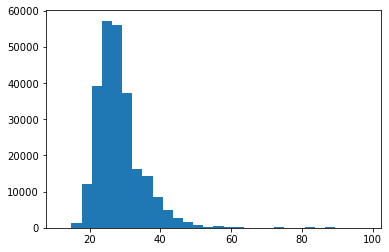

In [233]:
plt.hist(df.BMI, bins=30)